# Orbitrap-results-collate

Collates results from M0 and no-M0 experiments, calculates $\Delta^{17}O$ and clumped $\Delta$ values for each sample

1. Loads both M0 and noM0 data for the same samples
2. Calculates and plots their $\Delta^{17}O$ values
3. Calculates and plots their clumped $\Delta$ values
4. Saves all results in a single CSV

### $\Delta^{17}O$ anomoly calculation
Uses linear formula:  
##### $\Delta^{17}O = \delta^{17}O - 0.52 \times\delta^{18}O $

### Clumped $\Delta$ calculation
Calculates enrichments in clumped isotopologues w.r.t. a stochastic distribution using the following formula (e.g. for $^{15}$N$^{16}$O $_{2}$$ ^{18}$O):

#### $\Delta_{1518,sample}=\frac{\delta_{1518}+1}{(\delta_{15}+1)(f\delta_{18}+1)}\times (\Delta_{1518,reference}+1)-1$

Where the reference, UGSG35, defines the zero of the $\Delta$ scale and $f$ is a factor accounting for the isotopologue



### Import packages, user inputs

In [484]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# Inputs:
paths = {'M0':'240222_std_test_1_M0/external_deltas_summary_2024-03-07.csv',
         'noM0':'240222_std_test_1_noM0/external_deltas_summary_2024-03-07.csv'}
# paths = {'M0':'240208_CdD_202-215_M0/calibrated_deltas_2024-02-28.csv',
#          'noM0':'240212_CdD_202-215_noM0/calibrated_deltas_2024-03-01.csv'}

# paths = {'M0':'240229_CdD_202-215_syringe_2/calibrated_deltas_2024-02-29.csv'}

## 1. Load data


In [485]:
data = paths.copy()
# load both experiment results
for key in data.keys():
    data[key] = pd.read_csv(paths[key])
    data[key].index=data[key]['sample_name']
    data[key].drop('sample_name',axis=1,inplace=True)  
    
# merge both experiment results
if [key for key in paths.keys()] == ['M0','noM0']:
    data_compiled = pd.merge(data['M0'],data['noM0'],
                         left_index=True, right_index=True, how='outer', suffixes=['','_noM0'])
    print('Loaded M0 and noM0 data')
    
else:
    data_compiled = data['M0'].copy()
    print('Loaded M0 data only')

# drop entirely nan columns
data_compiled.dropna(axis=1,how='all',inplace=True)

data_compiled.head(10)

Loaded M0 and noM0 data


,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O,mean_d17O_noM0,mean_d18O_noM0,mean_d15N18O,mean_d17O18O,mean_d18O18O,err_d17O_noM0,err_d18O_noM0,err_d15N18O,err_d17O18O,err_d18O18O
sample_name,,,,,,,,,,,,,,,,
USGS34,-0.003358,-0.017856,-0.030626,0.000514,0.000969,0.000473,-0.011416,-0.021908,-0.029413,-0.059570,-0.056832,0.004364,0.007492,0.002842,0.006997,0.017339
USGS35,0.001469,0.049764,0.051311,0.000556,0.000792,0.000413,0.047912,0.050149,0.050328,0.083274,0.081069,0.000265,0.000150,0.000715,0.002006,0.000678


## 2. Calculate $\Delta^{17}O$ values

For both M0 and noM0 experiments

In [486]:
if [key for key in paths.keys()] == ['M0','noM0']:
    D17_df = pd.DataFrame(columns = ['mean_D17O', 'err_D17O','mean_D17O_noM0', 'err_D17O_noM0'])
    for exp in ['','_noM0']:
        D17_df['mean_D17O'+exp] = data_compiled['mean_d17O'+exp] - 0.52 * data_compiled['mean_d18O'+exp]
        D17_df['err_D17O'+exp] = (data_compiled['err_d17O'+exp]**2 - (0.52 * data_compiled['err_d18O'+exp])**2 )**0.5  

else:
    D17_df = pd.DataFrame(columns = ['mean_D17O', 'err_D17O'])
    exp=''
    D17_df['mean_D17O'+exp] = data_compiled['mean_d17O'+exp] - 0.52 * data_compiled['mean_d18O'+exp]
    D17_df['err_D17O'+exp] = (data_compiled['err_d17O'+exp]**2 - (0.52 * data_compiled['err_d18O'+exp])**2 )**0.5

D17_df*1e3


,mean_D17O,err_D17O,mean_D17O_noM0,err_D17O_noM0
sample_name,,,,
USGS34,-1.930311,0.937540,-0.024007,1.965380
USGS35,23.082689,0.762651,21.834648,0.253145


## 3. Calcualte clumped $\Delta$ values

- Take $\delta^{15}N$, $\delta^{17}O$ and $\delta^{18}O$ from M0 experiment
- Take $\delta^{15}N^{18}O$, $\delta^{17}O^{18}O$ and $\delta^{18}O^{18}O$ from no-M0 experiment  
  
Uses the formula:
### $\Delta_{AB_{sample - USGS35}}=\frac{\delta_{AB}+1}{(\delta_{A}+1)(f\delta_{B}+1)} -1$

With calibrated sample deltas. Sample clumped deltas are calibrated assuming dried USGS35 has a stochastic composition.

`dict` contains `[ f , isotope A, isotope B ]` for each doubly-substituted isotopologue  
where `f` is multiplied by the simple delta values to calculate the stochastic compositions.  

$f=1$ for N-O and S-O clumps, $f=2/3$ for O-O clumps in nitrate, and $f=3/4$ for O-O clumps in sulphate.


In [487]:
if [key for key in paths.keys()] == ['M0','noM0']:
    
    dict = {'15N18O':[1, '15N','18O'],
           '17O18O':[2/3, '17O','18O'],
            '18O18O':[2/3, '18O','18O']}
    clumps_df = pd.DataFrame(columns = ['mean_D'+iso for iso in dict.keys() if 'mean_d'+iso in data_compiled.columns]+
                                       ['err_D'+iso for iso in dict.keys() if 'err_d'+iso in data_compiled.columns])

    for clump,list in dict.items():

        if 'mean_d'+clump in data_compiled.columns:
            d_clump = data_compiled['mean_d'+clump]
            d_denom_1 = data_compiled['mean_d'+list[1]]
            d_denom_2 = data_compiled['mean_d'+list[2]]
            f = list[0]
            err_d_clump = data_compiled['err_d'+clump]
            err_d_denom_1 = data_compiled['err_d'+list[1]]
            err_d_denom_2 = data_compiled['err_d'+list[2]]

            Delta = (d_clump+1)/((d_denom_1+1)*(d_denom_2*f+1)) - 1
            Delta_err = (err_d_clump**2+err_d_denom_1**2+err_d_denom_2**2)**0.5

            clumps_df['mean_D'+clump]=Delta
            clumps_df['err_D'+clump]=Delta_err

            
else:
    clumps_df=pd.DataFrame()
    print('No noM0 data found')
    
clumps_df*1000

,mean_D15N18O,mean_D17O18O,mean_D18O18O,err_D15N18O,err_D17O18O,err_D18O18O
sample_name,,,,,,
USGS34,4.624950,-22.515892,-6.755261,2.926601,7.079133,17.351542
USGS35,-2.400037,-2.210988,-5.706620,0.995256,2.195651,0.895438


## 4. Collation of results

In [488]:
results_delta = data_compiled.copy()
results_D17 = D17_df.copy()
results_clumps = clumps_df.copy()

# merge the 3 dataframes
results_all = pd.merge(results_delta,results_D17,left_index=True,right_index=True,how='outer')
results_all = pd.merge(results_all,results_clumps,left_index=True,right_index=True,how='outer')

print('Collated the following channels:\n',
      [col[5:] for col in results_all.columns if col.startswith('mean_')],'\n',
      'For the following samples:\n',
      [sam for sam in results_all.index]
      )

# Display main columns
results_all[[ col for col in results_all.columns if col.startswith('mean_') and not col.endswith('_noM0')]]*1e3

# Save
results_all.to_csv(os.path.join(str(paths['M0'].split('/')[0]),'results_all_'+current_date_string+'.csv'))

Collated the following channels:
 ['d15N', 'd17O', 'd18O', 'd17O_noM0', 'd18O_noM0', 'd15N18O', 'd17O18O', 'd18O18O', 'D17O', 'D17O_noM0', 'D15N18O', 'D17O18O', 'D18O18O'] 
 For the following samples:
 ['USGS34', 'USGS35']


## 5. Plots

Plotting ['d15N', 'd17O', 'd18O', 'd17O18O', 'd18O18O', 'D17O', 'D15N18O', 'D17O18O', 'D18O18O'] for samples #0 to #1


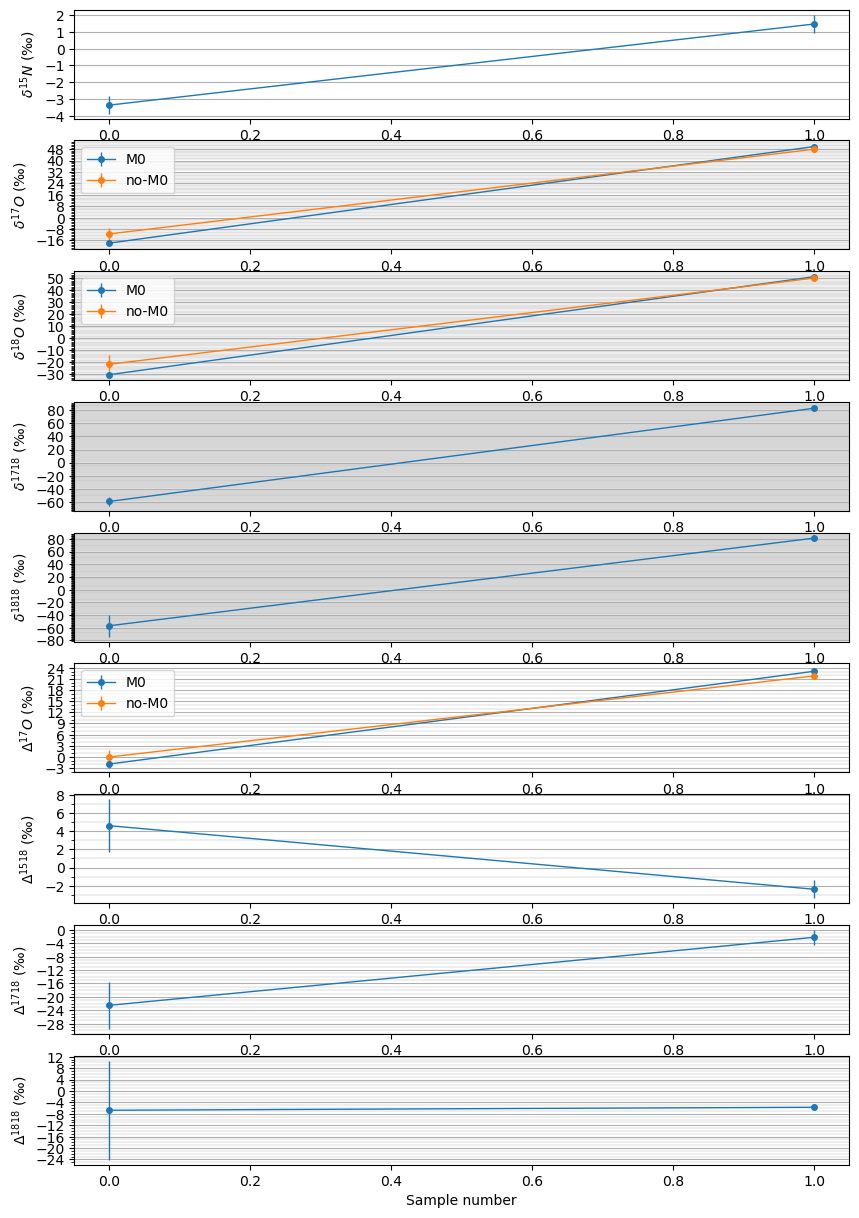

In [493]:
# sample_numbers = [ int(name[-3:]) for name in results_all.index ]
sample_numbers = [0,1]
channels_to_plot = [ col[5:] for col in results_all.columns 
                    if col.startswith('mean_') 
                    and not col.endswith('_noM0') 
                    # and not col=='mean_d17O' 
                    and not col=='mean_d15N18O' ]
display_names = ['$' + '\\' + col[0] + 'elta^{' + col[1:3] + '}' + col[3] + '$'  if len(col)==4
                 else '$' + '\\' + col[0] + 'elta^{' + col[1:3] + col[4:6] + '} $'
                 for col in channels_to_plot]
print('Plotting '+str(channels_to_plot)+' for samples #'+str(sample_numbers[0])+ ' to #' + str(sample_numbers[-1]))


fig,ax = plt.subplots(len(channels_to_plot),1, figsize=[10,15])

for i,ch in enumerate(channels_to_plot):
    # plot data with errorbars
    ax[i].errorbar(sample_numbers,results_all['mean_'+ch]*1e3, yerr = results_all['err_'+ch]*1e3, lw=1,marker='o',markersize=4,label='M0')
    if 'mean_'+ch+'_noM0' in results_all.columns:
        # also plot no-M0 data
        ax[i].errorbar(sample_numbers,results_all['mean_'+ch+'_noM0']*1e3, yerr = results_all['err_'+ch+'_noM0']*1e3, lw=1,marker='o',markersize=4,label='no-M0')
        ax[i].legend()
    
    #  parameters
    ax[i].set_ylabel( display_names[i]+' (‰)')
    ax[-1].set_xlabel('Sample number')
    # add y ticks at unit spacing
    ax[i].set_yticks([i for i in range(int(ax[i].get_ylim()[0]),int(ax[i].get_ylim()[1]))], minor=True)
    ax[i].grid(axis='y')
    ax[i].grid(axis='y', which='minor',lw=0.3)
    ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))


In [475]:
fig.savefig('fig.png')

In [490]:
results_all

,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O,mean_d17O_noM0,mean_d18O_noM0,mean_d15N18O,mean_d17O18O,...,mean_D17O,err_D17O,mean_D17O_noM0,err_D17O_noM0,mean_D15N18O,mean_D17O18O,mean_D18O18O,err_D15N18O,err_D17O18O,err_D18O18O
sample_name,,,,,,,,,,,,,,,,,,,,,
USGS34,-0.003358,-0.017856,-0.030626,0.000514,0.000969,0.000473,-0.011416,-0.021908,-0.029413,-0.059570,...,-0.001930,0.000938,-0.000024,0.001965,0.004625,-0.022516,-0.006755,0.002927,0.007079,0.017352
USGS35,0.001469,0.049764,0.051311,0.000556,0.000792,0.000413,0.047912,0.050149,0.050328,0.083274,...,0.023083,0.000763,0.021835,0.000253,-0.002400,-0.002211,-0.005707,0.000995,0.002196,0.000895
